## Multiple Linear Regression, the Hard Way

### Goals

- Extend our understanding of the linear regression model to multiple features

We're going to do the house-price-prediction example, but doing the linear regression part by hand, like we did last week with the single-feature case.

## Setup

Let's import necessary modules: *pandas* and NumPy for data wrangling, Matplotlib for plotting, and some sklearn utilities. We'll be implementing the linear regression model ourselves, so we don't need to import it from sklearn.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import scipy.optimize

We'll load the data as before.

In [4]:
ames = pd.read_csv('https://github.com/kcarnold/AmesHousing/blob/master/data/ames.csv.gz?raw=true', compression="gzip")
ames['price'] = ames["Sale_Price"] / 100_000 # Make `price` be in units of $100k, to be easier to interpret.


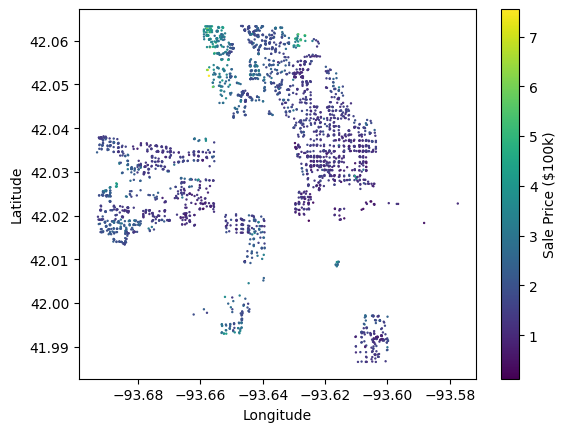

In [5]:
def plot_data():
    # You don't have to know how this function works.
    plt.scatter(ames['Longitude'], ames['Latitude'], c=ames["price"], s=.5)
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.colorbar(label="Sale Price ($100k)")
plot_data()

In [6]:
feature_names = ['Longitude', 'Latitude']
X = ames[feature_names].values
X.shape

(2930, 2)

Our target, called `y` by convention, will be the home price (we'll soon introduce a different *y*, but start with this one).

In [7]:
y = ames['price'].values
y.shape

(2930,)

Notice that `X` has two axes and thus is written in uppercase; `y` has 1 and thus is written in lowercase. (This is `sklearn` convention; other libraries are less consistent about this.)

Now let's split the data into a `train` and `valid` set (which sklearn calls train-*test*, but that's fine). `random_state` is how `sklearn` specifies the random seed (it's actually slightly more flexible than a seed).

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, random_state=42)

We'll verify that the shapes make sense. Note how many items are in each of the sets.

In [9]:
X_train.shape, y_train.shape

((2344, 2), (2344,))

In [10]:
X_valid.shape, y_valid.shape

((586, 2), (586,))

Here's a function to plot our regression model in "data space" (i.e., what it would predict everywhere on the map).

This function is pretty customized to our specific use case, though you can get inspiration from it for use in other situations.

In [11]:
def plot_model(prediction_fn, fig=None, prediction_args=()):
    # Compute extents
    lat_min = ames.Latitude.min()
    lat_max = ames.Latitude.max()
    lon_min = ames.Longitude.min()
    lon_max = ames.Longitude.max()
    price_min = ames.price.min()
    price_max = ames.price.max()

    # Ask the classifier for predictions on a grid
    xx, yy = np.meshgrid(np.linspace(lon_min, lon_max, 250), np.linspace(lat_min, lat_max, 250))
    Z = prediction_fn(np.c_[xx.ravel(), yy.ravel()], *prediction_args).reshape(xx.shape)

    if fig is None:
        fig = plt.figure(figsize=plt.figaspect(2))

    # Left side: show the predictions in 2D. Superimpose the original data.
    ax = fig.add_subplot(2, 1, 1)
    surf = ax.contourf(xx, yy, Z, alpha=.5, cmap=plt.cm.viridis, vmin=price_min, vmax=price_max)
    ax.scatter(ames['Longitude'], ames['Latitude'], c=ames["price"], s=1, cmap='viridis', vmin=price_min, vmax=price_max)
    ax.set(xlabel="Longitude", ylabel="Latitude", title="2D contour view")
    fig.colorbar(surf, label="Sale Price ($100k)")

    # Right side: show the predictions in 3D
    ax = fig.add_subplot(2, 1, 2, projection='3d')
    ax.plot_surface(xx, yy, Z, alpha=.5, cmap=plt.cm.viridis, vmin=price_min, vmax=price_max)
    #ax.scatter(ames['Longitude'], ames['Latitude'], c=ames["price"], s=1, cmap='viridis', vmin=price_min, vmax=price_max)
    ax.set(title="3D view")

## Task

### Part A: Linear regression

Step A1: **Fit a linear regression model to the training set (`X_train`, `y_train`).**

Last time you did this, you used `sklearn`. This time, you'll do it by hand. You'll need to calculate the coefficients `w` and `b` that minimize the mean squared error (MSE) between the model's predictions and the actual values.

I'll walk you through this. First, we'll work on making a single prediction. To do that, we'll need some `weights` and a `bias`, which we'll initialize randomly. **Think about what shape these should be.**

In [15]:
np.random.seed(42)

weights = np.random.standard_normal(size=2) # for each feature
bias = np.random.standard_normal()
weights, bias

(array([ 0.49671415, -0.1382643 ]), 0.6476885381006925)

Now we'll make a single prediction. Think about how you can do this using a dot product.

In [16]:
x_i = X_train[0] # example data point
y_pred_i = x_i @ weights + bias
y_pred_i

-51.67595519554893

Next we'll make a prediction for every item in the training set. Think about how you can do this using a dot product.

In [32]:
def linreg_forward(X, weights, bias):
    return X @ weights + bias

y_pred_train = linreg_forward(X_train, weights, bias)
y_pred_train.shape

()


(2344,)

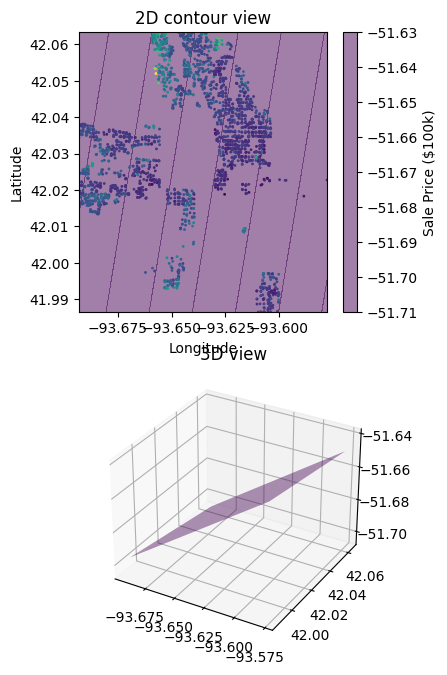

In [18]:
plot_model(linreg_forward, prediction_args=(weights, bias))

Now let's compute the loss and optimize it, as before.

In [25]:
def compute_mse_loss(y_true, y_pred):
    return sum(((y_true - y_pred)**2)/len(y_pred))

mse_loss = compute_mse_loss(y_train, y_pred_train)
print("MSE loss:", mse_loss)

MSE loss: 2858.9442548850398


We'll pack the parameters into a single vector, and then we'll use the `minimize` function from `scipy.optimize` to find the best parameters.

In [28]:
def unpack_params(params):
    weights = params[:-1]
    bias = params[-1]
    return weights, bias

def pack_params(weights, bias):
    return np.concatenate([weights, [bias]])

def loss_given_params(params, X, y_true):
    weights, bias = unpack_params(params)
    y_pred = linreg_forward(X, weights, bias)
    return compute_mse_loss(y_true, y_pred)

params = pack_params(weights, bias)
loss = loss_given_params(params, X_train, y_train)
print("loss:", loss) # should be the same as mse_loss above

loss: 2858.9442548850398


In [29]:
optimization_result = scipy.optimize.minimize(loss_given_params, params, args=(X_train, y_train))
fitted_params = optimization_result.x
weights, bias = unpack_params(fitted_params)
print("Fitted weights:", weights)
print("Fitted bias:", bias)

Fitted weights: [-8.04943863 11.84864352]
Fitted bias: -1250.0316020383893


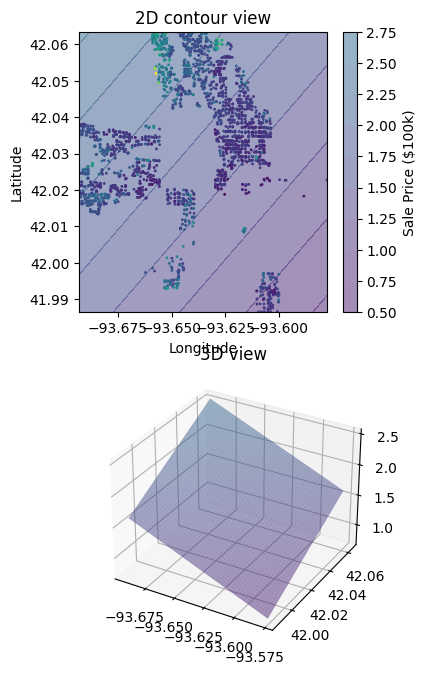

In [30]:
weights, bias = unpack_params(fitted_params)
plot_model(linreg_forward, prediction_args=(weights, bias))

## Analysis

1. What are the shapes of `X`, `y`, `w`, and `b`? Explain why each has the shape it does.

2. Suppose we were trying to predict the original, un-scaled sale price. (i.e., all of our predictions need to be multiplied by 100,000.) Could you adjust the model that we just trained to do that *without* needing to call `minimize` again? If so, how? If not, why not?

- **What are the shapes of `X`, `y`, `w`, and `b`? Explain why each has the shape it does.**
    + `X`: (2930, 2) -- 2930 cases and 2 features/variables (`Longitude`, `Latitude`)
    + `y`: (2930, ) -- 2930 target-cases.
    + `w`: (2,) -- 2 weights for each **feature**
    + `b`: () -- 1 bias was generated as a `scalar variable`
- That wouldn't be a problem. If every prediction was multiplied by such a scale, we'd just need to divide the outcomes by said scale and calculate the loss values.